# Network Intrusion Detection System (IDS) Analysis

## Project Abstract

**Problem**: Network intrusion detection is critical for cybersecurity. This project aims to classify network traffic as normal (benign) or malicious (attack) using machine learning techniques.

**Dataset**: Network flow data with 77 features including packet statistics, flow duration, protocol information, and various network metrics.

**Solutions**: We implement and compare multiple machine learning approaches:
- Logistic Regression with L1/L2 regularization
- Random Forest Classifier
- Neural Network (Multi-layer Perceptron)
- XGBoost
- LightGBM

**Note**: SVM was excluded due to O(n²) computational complexity being impractical for 360K samples.

---

## 1. Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Gradient Boosting Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Color palette for visualizations
MODEL_COLORS = {
    'Logistic Reg (L2)': '#3498db',
    'Logistic Reg (L1)': '#9b59b6',
    'Random Forest': '#2ecc71',
    'Neural Network': '#f39c12',
    'XGBoost': '#1abc9c',
    'LightGBM': '#e91e63'
}

print('Libraries loaded successfully!')

Libraries loaded successfully!


In [2]:
# Load the dataset - UPDATE THIS PATH
df = pd.read_csv('dataset.csv')  # <- Change to your file path

print(f'Dataset shape: {df.shape}')
print(f'Number of samples: {df.shape[0]:,}')
print(f'Number of features: {df.shape[1]}')
print('\nFirst few rows:')
df.head()

Dataset shape: (360000, 79)
Number of samples: 360,000
Number of features: 79

First few rows:


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3389,6,2156473,8,7,1128,1581.0,661,0,141.000000,...,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0
1,49876,6,144,2,0,0,0.0,0,0,0.000000,...,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0
2,47148,6,4560903,5,3,935,354.0,935,0,187.000000,...,32,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0
3,53,17,1218,1,1,40,139.0,40,40,40.000000,...,8,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0
4,443,6,115235164,23,17,1910,3988.0,1301,0,83.043478,...,20,217255.181818,609397.184141,2042693.0,11483.0,1.000008e+07,12463.972427,10003959.0,9962502.0,0


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Check data types and missing values
print('Data Types:')
print(df.dtypes.value_counts())
print('\nMissing Values:')
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0].sort_values(ascending=False).head(10))
else:
    print('No missing values found!')

Data Types:
int64      42
float64    37
Name: count, dtype: int64

Missing Values:
No missing values found!


Target Variable Distribution:
Label
0    40000
1    40000
2    40000
3    40000
4    40000
5    40000
6    40000
7    40000
8    40000
Name: count, dtype: int64

Class distribution (%):
Label
0    11.11
1    11.11
2    11.11
3    11.11
4    11.11
5    11.11
6    11.11
7    11.11
8    11.11
Name: proportion, dtype: float64


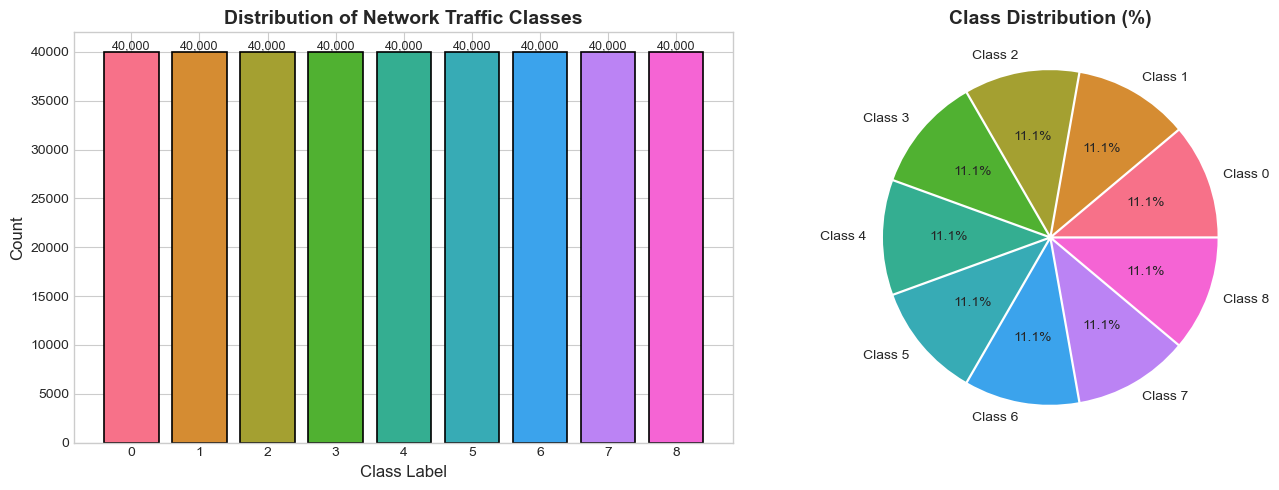

In [4]:
# Target variable distribution
print('Target Variable Distribution:')
print(df['Label'].value_counts())
print(f'\nClass distribution (%):')
print(df['Label'].value_counts(normalize=True).round(4) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df['Label'].value_counts().sort_index()
colors = sns.color_palette('husl', len(class_counts))
bars = axes[0].bar(class_counts.index.astype(str), class_counts.values, 
                   color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_title('Distribution of Network Traffic Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for bar in bars:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)

# Pie chart
axes[1].pie(class_counts.values, labels=[f'Class {i}' for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, explode=[0.02]*len(class_counts))
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Check and handle infinite values
print('Checking for infinite values...')
inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f'Found {inf_count} infinite values. Replacing with NaN...')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(numeric_only=True), inplace=True)
    print('Done!')
else:
    print('No infinite values found!')

Checking for infinite values...
No infinite values found!


## 3. Data Preprocessing

In [6]:
# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(le.classes_)

print(f'Feature matrix shape: {X.shape}')
print(f'Number of classes: {n_classes}')
print(f'Class mapping: {dict(zip(le.classes_, range(n_classes)))}')

Feature matrix shape: (360000, 78)
Number of classes: 9
Class mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f'Training set: {X_train.shape[0]:,} samples')
print(f'Test set: {X_test.shape[0]:,} samples')

Training set: 252,000 samples
Test set: 108,000 samples


In [8]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Feature scaling completed!')
print(f'Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}')

Feature scaling completed!
Mean: -0.000000, Std: 0.947331


## 4. PCA Analysis

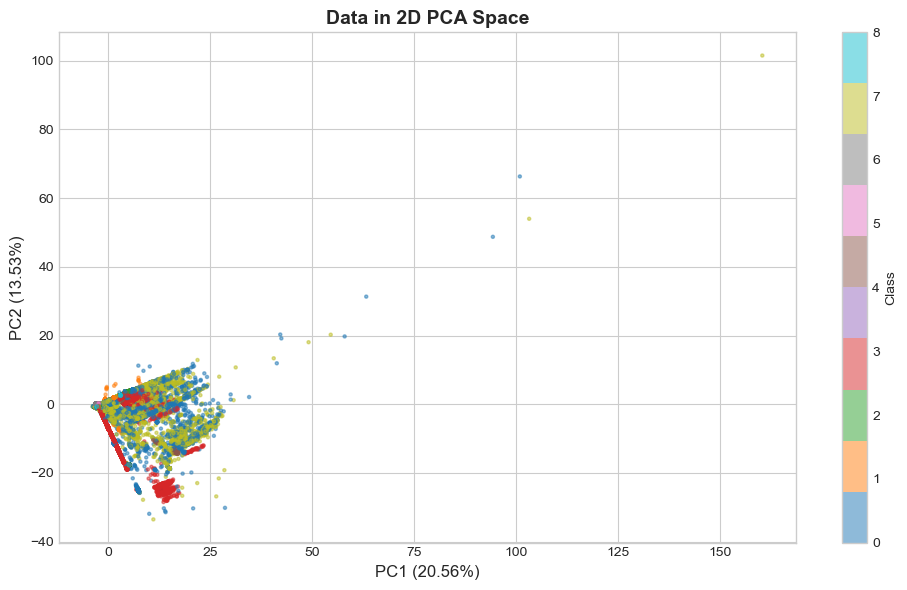

Variance explained by 2 components: 34.09%


In [9]:
# PCA visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=0.5, s=5)
plt.colorbar(scatter, label='Class')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.title('Data in 2D PCA Space', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('pca_2d.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Variance explained by 2 components: {pca_2d.explained_variance_ratio_.sum():.2%}')

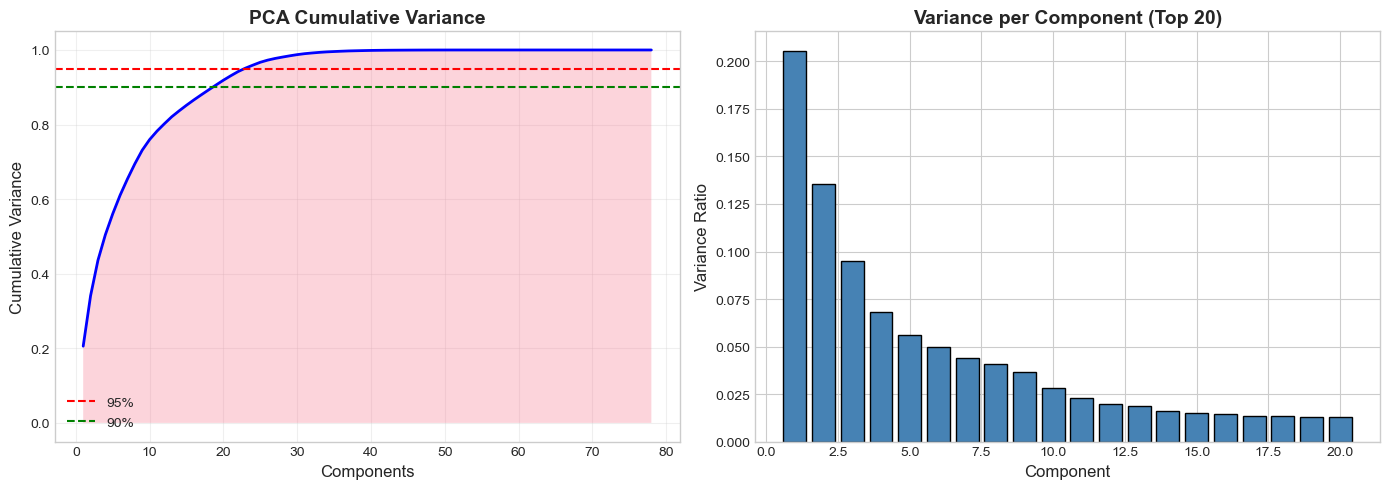

Components for 95% variance: 23
Components for 90% variance: 19


In [10]:
# Cumulative variance plot
pca_full = PCA(random_state=42).fit(X_train_scaled)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(cumsum)+1), cumsum, 'b-', linewidth=2)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[0].axhline(y=0.90, color='g', linestyle='--', label='90%')
axes[0].fill_between(range(1, len(cumsum)+1), cumsum, alpha=0.3)
axes[0].set_xlabel('Components', fontsize=12)
axes[0].set_ylabel('Cumulative Variance', fontsize=12)
axes[0].set_title('PCA Cumulative Variance', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(1, 21), pca_full.explained_variance_ratio_[:20], color='steelblue', edgecolor='black')
axes[1].set_xlabel('Component', fontsize=12)
axes[1].set_ylabel('Variance Ratio', fontsize=12)
axes[1].set_title('Variance per Component (Top 20)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Components for 95% variance: {np.argmax(cumsum >= 0.95) + 1}')
print(f'Components for 90% variance: {np.argmax(cumsum >= 0.90) + 1}')

## 5. Model Training

**Note**: SVM excluded due to O(n²) complexity - impractical for 360K samples.

In [11]:
# Model evaluation function with timing
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f'\n{"="*60}')
    print(f'Training {model_name}...')
    print(f'{"="*60}')
    
    # Train with timing
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    # Predict
    start = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start
    
    y_train_pred = model.predict(X_train)
    
    # Metrics
    metrics = {
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'train_time': train_time,
        'pred_time': pred_time
    }
    
    print(f'\nTraining Time: {train_time:.2f}s')
    print(f'Train Accuracy: {metrics["train_acc"]:.4f}')
    print(f'Test Accuracy:  {metrics["test_acc"]:.4f}')
    print(f'Precision: {metrics["precision"]:.4f}')
    print(f'Recall:    {metrics["recall"]:.4f}')
    print(f'F1-Score:  {metrics["f1"]:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    print(f'\nConfusion Matrix:\n{cm}')
    print(f'\nClassification Report:')
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return {
        'model': model,
        **metrics,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

### 5.1 Logistic Regression (L2)

In [12]:
logreg_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42, solver='lbfgs', n_jobs=-1)
results_logreg_l2 = evaluate_model(logreg_l2, X_train_scaled, X_test_scaled, y_train, y_test, 'Logistic Regression (L2)')


Training Logistic Regression (L2)...

Training Time: 75.21s
Train Accuracy: 0.8515
Test Accuracy:  0.8500
Precision: 0.8562
Recall:    0.8500
F1-Score:  0.8456

Confusion Matrix:
[[ 5832   353    39     4     0     3     0  5768     1]
 [    0 11988     0     0     0     0     0    12     0]
 [    5     0 11995     0     0     0     0     0     0]
 [    1     0     0 11994     5     0     0     0     0]
 [    0     0     0     9 11991     0     0     0     0]
 [    0     0     0     0     0  6609  5391     0     0]
 [    0     0     0     0     0  2577  9423     0     0]
 [ 1616   353    24     9    21     2     0  9973     2]
 [    0     0     0     0     0     0     1     0 11999]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.49      0.60     12000
           1       0.94      1.00      0.97     12000
           2       0.99      1.00      1.00     12000
           3       1.00      1.00      1.00     12000
           

### 5.2 Logistic Regression (L1)

In [13]:
logreg_l1 = LogisticRegression(penalty='l1', C=1.0, max_iter=1000, random_state=42, solver='saga', n_jobs=-1)
results_logreg_l1 = evaluate_model(logreg_l1, X_train_scaled, X_test_scaled, y_train, y_test, 'Logistic Regression (L1)')


Training Logistic Regression (L1)...

Training Time: 1083.18s
Train Accuracy: 0.8423
Test Accuracy:  0.8410
Precision: 0.8439
Recall:    0.8410
F1-Score:  0.8365

Confusion Matrix:
[[ 6008   727    72    16     8    33     0  5115    21]
 [    1 11832     0     0     0     0     0   167     0]
 [    0     0 12000     0     0     0     0     0     0]
 [    1     0     0 11789   210     0     0     0     0]
 [    3     0     0    13 11984     0     0     0     0]
 [    0     0     0     0     0  6609  5391     0     0]
 [    0     0     0     0     0  2577  9423     0     0]
 [ 1909   777    42    17    43    13     0  9189    10]
 [    0     0     0     0     0     0     1     0 11999]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.50      0.60     12000
           1       0.89      0.99      0.93     12000
           2       0.99      1.00      1.00     12000
           3       1.00      0.98      0.99     12000
         

### 5.3 Random Forest

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, 
                                   min_samples_leaf=2, random_state=42, n_jobs=-1)
results_rf = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Random Forest')


Training Random Forest...

Training Time: 6.98s
Train Accuracy: 0.9064
Test Accuracy:  0.8852
Precision: 0.9039
Recall:    0.8852
F1-Score:  0.8797

Confusion Matrix:
[[ 8760     7     5     0     0     0     0  3228     0]
 [    0 11996     0     0     0     0     0     4     0]
 [    0     0 11998     0     0     0     0     2     0]
 [    0     0     0 11998     1     0     0     1     0]
 [    0     0     0     0 12000     0     0     0     0]
 [    0     0     0     0     0 11587   413     0     0]
 [    0     0     0     0     0  6893  5107     0     0]
 [ 1826    13     3     3     0     2     1 10152     0]
 [    0     0     0     0     0     0     1     0 11999]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78     12000
           1       1.00      1.00      1.00     12000
           2       1.00      1.00      1.00     12000
           3       1.00      1.00      1.00     12000
           4       1.00

Top 15 Features:
              feature  importance
66  Init Fwd Win Byts    0.095058
0            Dst Port    0.093460
69   Fwd Seg Size Min    0.093287
17      Flow IAT Mean    0.052181
35     Fwd Header Len    0.052106
16        Flow Pkts/s    0.039868
37         Fwd Pkts/s    0.039242
38         Bwd Pkts/s    0.031212
19       Flow IAT Max    0.030862
21        Fwd IAT Tot    0.028703
22       Fwd IAT Mean    0.027209
2       Flow Duration    0.026224
20       Flow IAT Min    0.024624
67  Init Bwd Win Byts    0.023950
25        Fwd IAT Min    0.023647


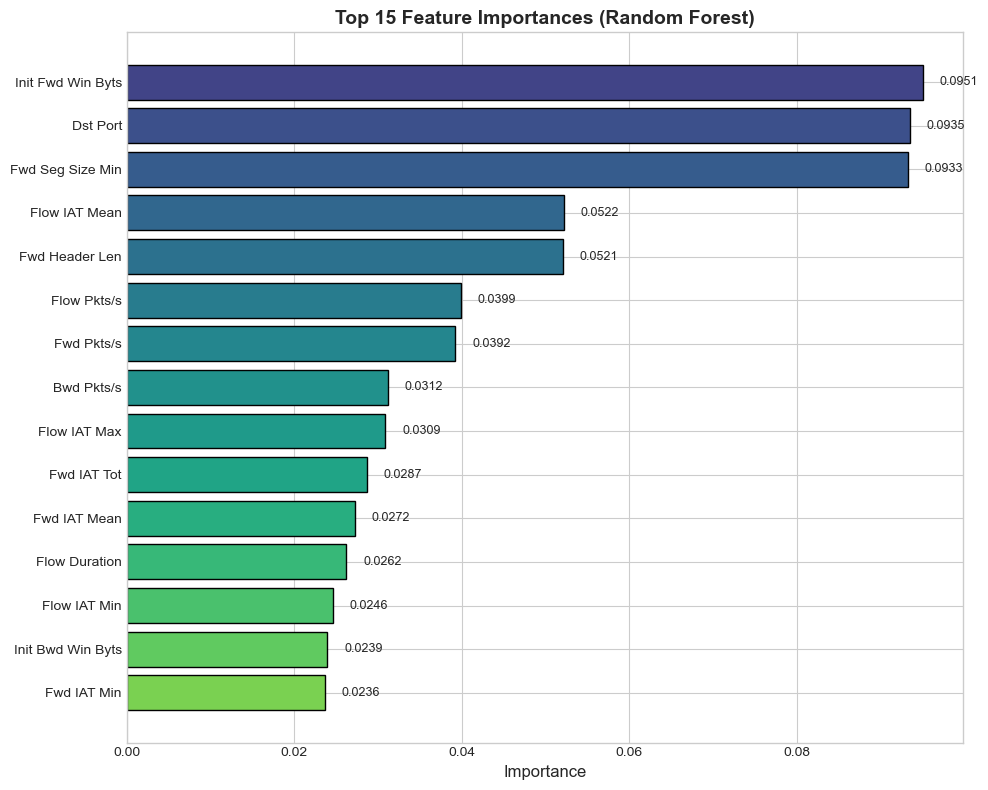

In [15]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': results_rf['model'].feature_importances_
}).sort_values('importance', ascending=False)

print('Top 15 Features:')
print(feature_importance.head(15))

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
top15 = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 15))
bars = ax.barh(range(15), top15['importance'], color=colors, edgecolor='black')
ax.set_yticks(range(15))
ax.set_yticklabels(top15['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, top15['importance']):
    ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Neural Network (MLP)

In [16]:
nn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu', solver='adam', alpha=0.0001,
    batch_size=256, learning_rate='adaptive', learning_rate_init=0.001,
    max_iter=200, random_state=42, early_stopping=True,
    validation_fraction=0.1, n_iter_no_change=10
)
results_nn = evaluate_model(nn_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Neural Network')


Training Neural Network...

Training Time: 109.22s
Train Accuracy: 0.8741
Test Accuracy:  0.8726
Precision: 0.8844
Recall:    0.8726
F1-Score:  0.8689

Confusion Matrix:
[[ 7037     1     0     2     0     0     0  4960     0]
 [    3 11997     0     0     0     0     0     0     0]
 [    0     0 12000     0     0     0     0     0     0]
 [    1     0     0 11996     3     0     0     0     0]
 [    0     0     0     5 11995     0     0     0     0]
 [    0     0     0     0     0  6117  5883     0     0]
 [    0     0     0     0     0  1371 10629     0     0]
 [ 1514     0     0     6     0     3     2 10475     0]
 [    0     0     0     0     0     0     1     0 11999]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.59      0.68     12000
           1       1.00      1.00      1.00     12000
           2       1.00      1.00      1.00     12000
           3       1.00      1.00      1.00     12000
           4       1

### 5.5 XGBoost

In [17]:
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=10, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, eval_metric='mlogloss'
)
results_xgb = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, 'XGBoost')


Training XGBoost...

Training Time: 11.57s
Train Accuracy: 0.9015
Test Accuracy:  0.8886
Precision: 0.8957
Recall:    0.8886
F1-Score:  0.8865

Confusion Matrix:
[[ 8747     0     2     1     0     0     0  3250     0]
 [    1 11999     0     0     0     0     0     0     0]
 [    0     0 12000     0     0     0     0     0     0]
 [    0     0     0 11999     0     0     0     1     0]
 [    0     0     0     0 12000     0     0     0     0]
 [    0     0     0     0     0  6409  5591     0     0]
 [    0     0     0     0     0  1514 10486     0     0]
 [ 1662     0     1     3     0     1     2 10331     0]
 [    0     0     0     0     0     0     1     0 11999]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78     12000
           1       1.00      1.00      1.00     12000
           2       1.00      1.00      1.00     12000
           3       1.00      1.00      1.00     12000
           4       1.00     

### 5.6 LightGBM

In [18]:
lgbm_model = LGBMClassifier(
    n_estimators=100, max_depth=10, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, verbose=-1
)
results_lgbm = evaluate_model(lgbm_model, X_train_scaled, X_test_scaled, y_train, y_test, 'LightGBM')


Training LightGBM...

Training Time: 12.14s
Train Accuracy: 0.9175
Test Accuracy:  0.9127
Precision: 0.9243
Recall:    0.9127
F1-Score:  0.9102

Confusion Matrix:
[[ 9730     0     0     1     0     0     0  2269     0]
 [    0 11999     0     0     0     0     0     1     0]
 [    0     0 12000     0     0     0     0     0     0]
 [    0     0     0 11999     0     0     0     1     0]
 [    0     0     0     0 12000     0     0     0     0]
 [    0     0     0     0     0  6486  5514     0     0]
 [    0     0     0     0     0   648 11352     0     0]
 [  982     0     0     2     0     3     1 11012     0]
 [    0     0     0     0     0     0     1     0 11999]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86     12000
           1       1.00      1.00      1.00     12000
           2       1.00      1.00      1.00     12000
           3       1.00      1.00      1.00     12000
           4       1.00    

## 6. Model Comparison

In [19]:
# Compile results
model_results = {
    'Logistic Reg (L2)': results_logreg_l2,
    'Logistic Reg (L1)': results_logreg_l1,
    'Random Forest': results_rf,
    'Neural Network': results_nn,
    'XGBoost': results_xgb,
    'LightGBM': results_lgbm
}

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train Acc': [r['train_acc'] for r in model_results.values()],
    'Test Acc': [r['test_acc'] for r in model_results.values()],
    'Precision': [r['precision'] for r in model_results.values()],
    'Recall': [r['recall'] for r in model_results.values()],
    'F1-Score': [r['f1'] for r in model_results.values()],
    'Train Time (s)': [r['train_time'] for r in model_results.values()]
})

print('\n' + '='*90)
print('MODEL COMPARISON SUMMARY')
print('='*90)
print(comparison_df.to_string(index=False))
print('='*90)

best_idx = comparison_df['Test Acc'].idxmax()
print(f"\n🏆 Best Model: {comparison_df.loc[best_idx, 'Model']} (Test Acc: {comparison_df.loc[best_idx, 'Test Acc']:.4f})")


MODEL COMPARISON SUMMARY
            Model  Train Acc  Test Acc  Precision   Recall  F1-Score  Train Time (s)
Logistic Reg (L2)   0.851496  0.850037   0.856168 0.850037  0.845572       75.207886
Logistic Reg (L1)   0.842290  0.841046   0.843927 0.841046  0.836503     1083.179767
    Random Forest   0.906373  0.885157   0.903886 0.885157  0.879661        6.976861
   Neural Network   0.874135  0.872639   0.884441 0.872639  0.868917      109.216698
          XGBoost   0.901464  0.888611   0.895692 0.888611  0.886456       11.568451
         LightGBM   0.917484  0.912750   0.924320 0.912750  0.910221       12.140464

🏆 Best Model: LightGBM (Test Acc: 0.9127)


## 7. Visualizations

### 7.1 Model Comparison (Zoomed Y-axis)

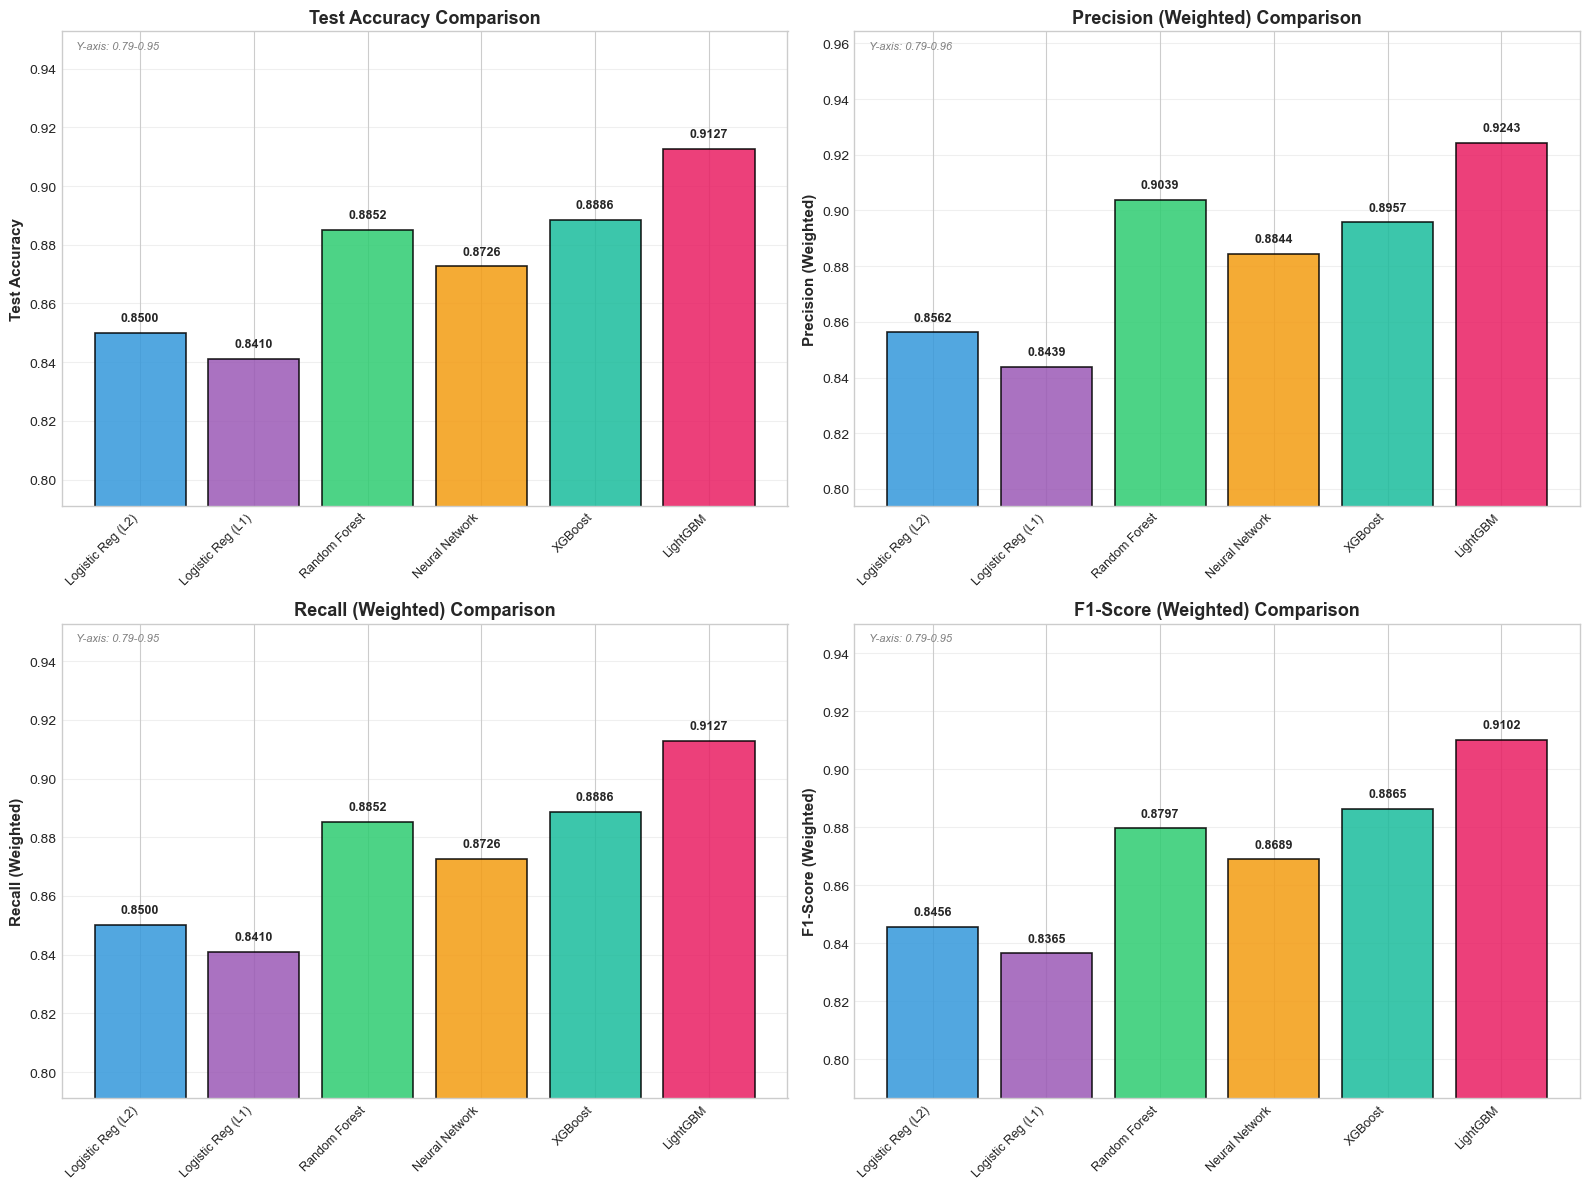

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Test Acc', 'Precision', 'Recall', 'F1-Score']
titles = ['Test Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']

for ax, metric, title in zip(axes.flat, metrics, titles):
    values = comparison_df[metric].values
    models = comparison_df['Model'].values
    colors = [MODEL_COLORS[m] for m in models]
    
    bars = ax.bar(range(len(models)), values, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., val + 0.003,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Zoom y-axis
    y_min = max(0, min(values) - 0.05)
    y_max = min(1.0, max(values) + 0.04)
    ax.set_ylim([y_min, y_max])
    
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(f'{title} Comparison', fontsize=13, fontweight='bold')
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.text(0.02, 0.98, f'Y-axis: {y_min:.2f}-{y_max:.2f}', transform=ax.transAxes,
            fontsize=8, va='top', style='italic', color='gray')

plt.tight_layout()
plt.savefig('model_comparison_zoomed.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.2 Radar Chart

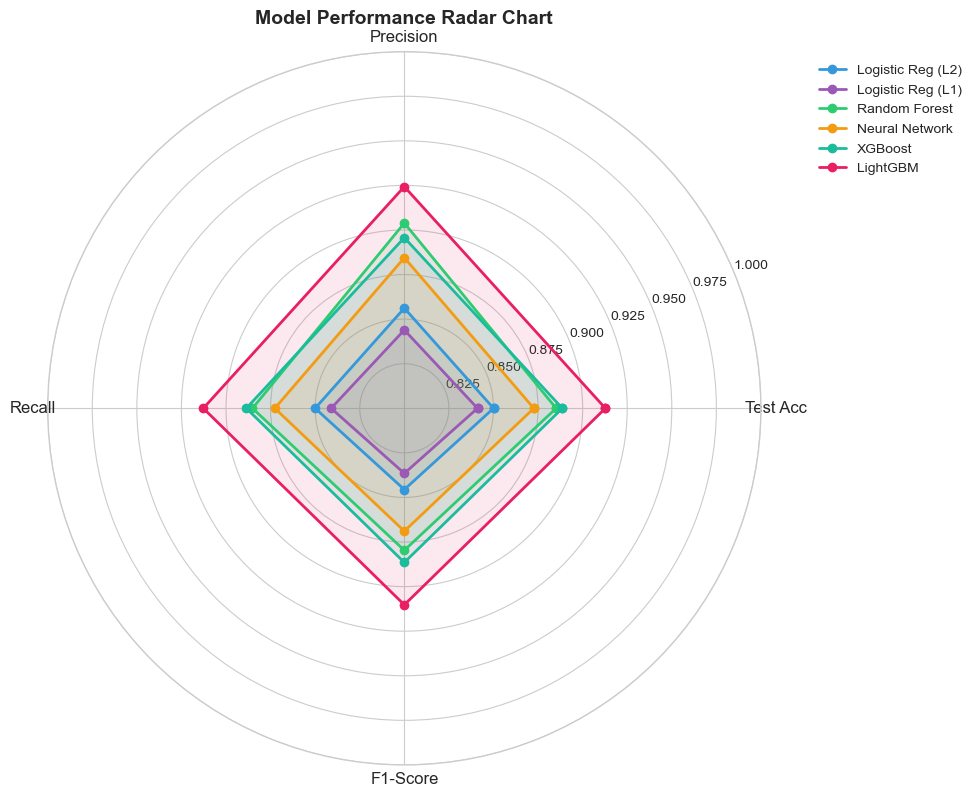

In [21]:
from math import pi

categories = ['Test Acc', 'Precision', 'Recall', 'F1-Score']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for model_name, results in model_results.items():
    values = [results['test_acc'], results['precision'], results['recall'], results['f1']]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=MODEL_COLORS[model_name])
    ax.fill(angles, values, alpha=0.1, color=MODEL_COLORS[model_name])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0.8, 1.0)
ax.set_title('Model Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.3 Confusion Matrices

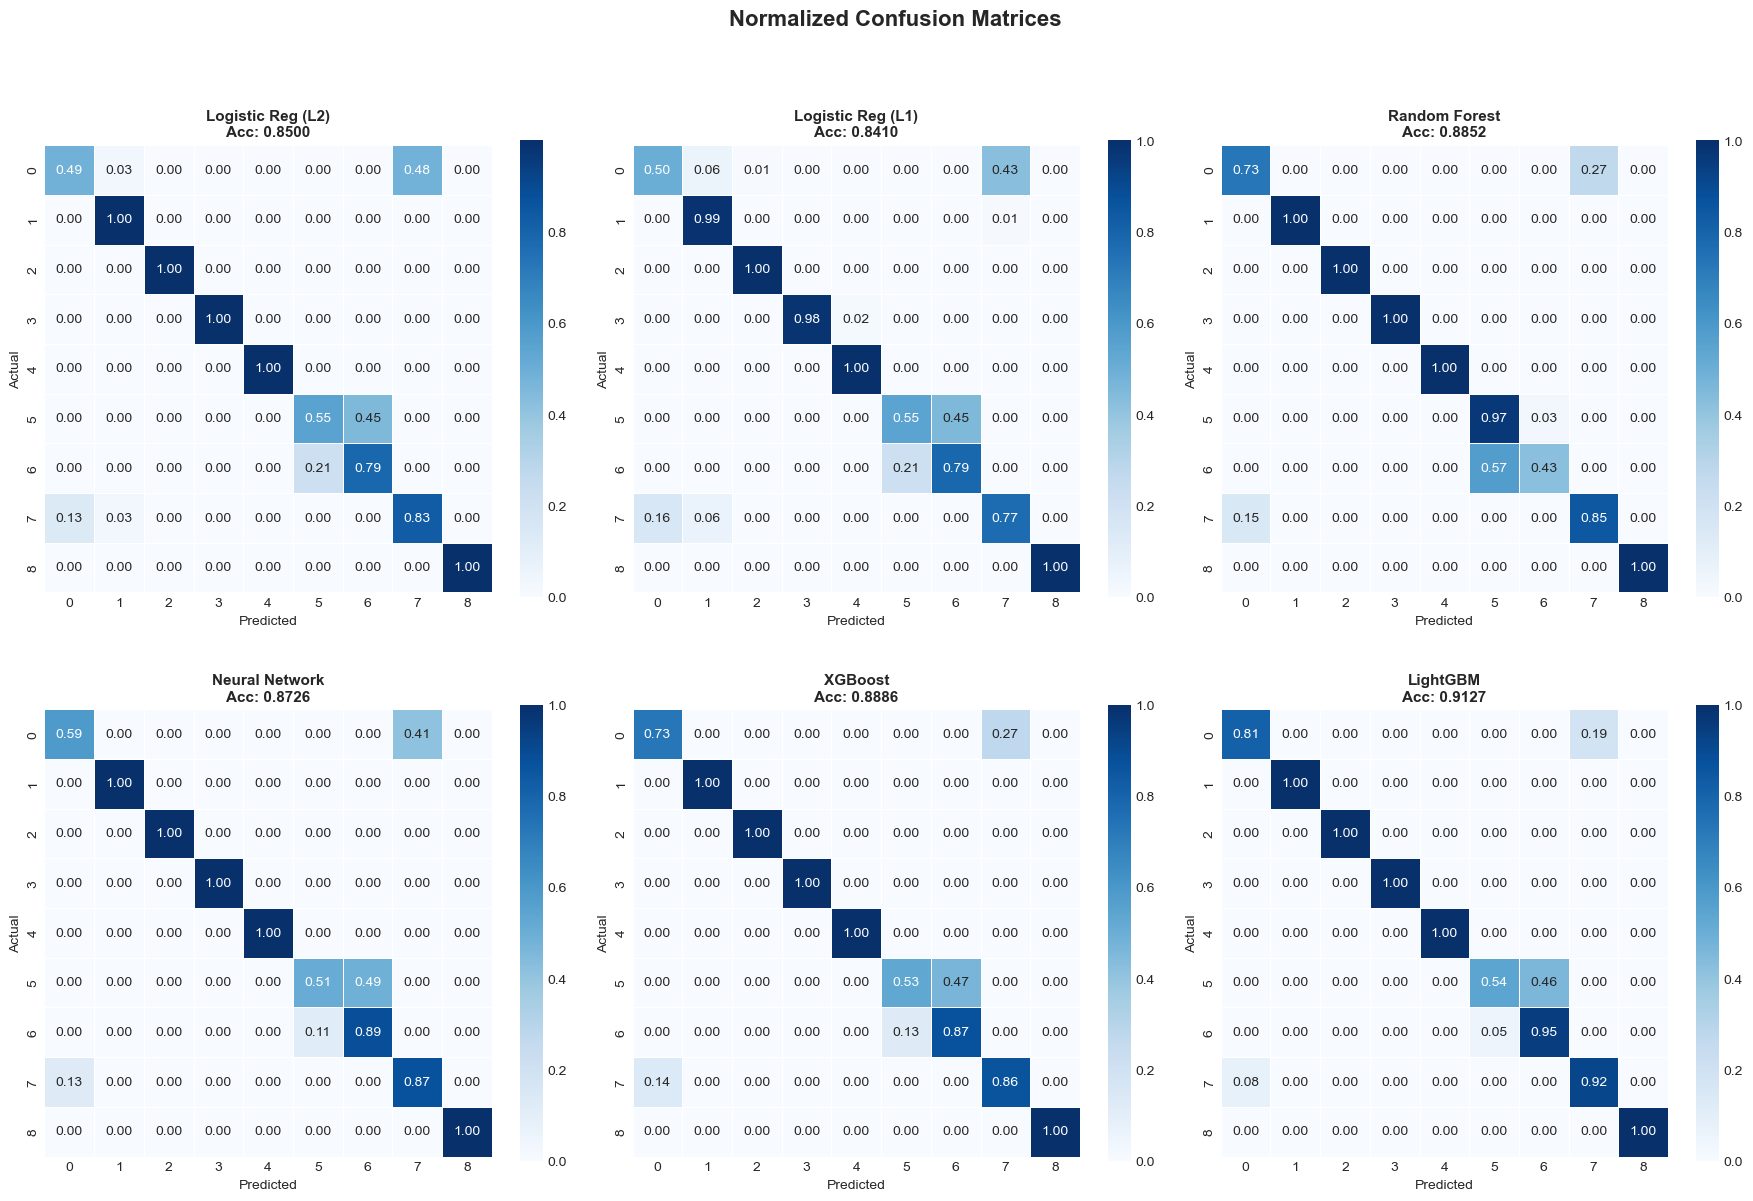

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(model_results.items()):
    ax = axes[idx]
    cm = results['confusion_matrix']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                cbar_kws={'shrink': 0.8}, square=True, linewidths=0.5)
    ax.set_title(f'{model_name}\nAcc: {results["test_acc"]:.4f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)

plt.suptitle('Normalized Confusion Matrices', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.4 Training Time Comparison

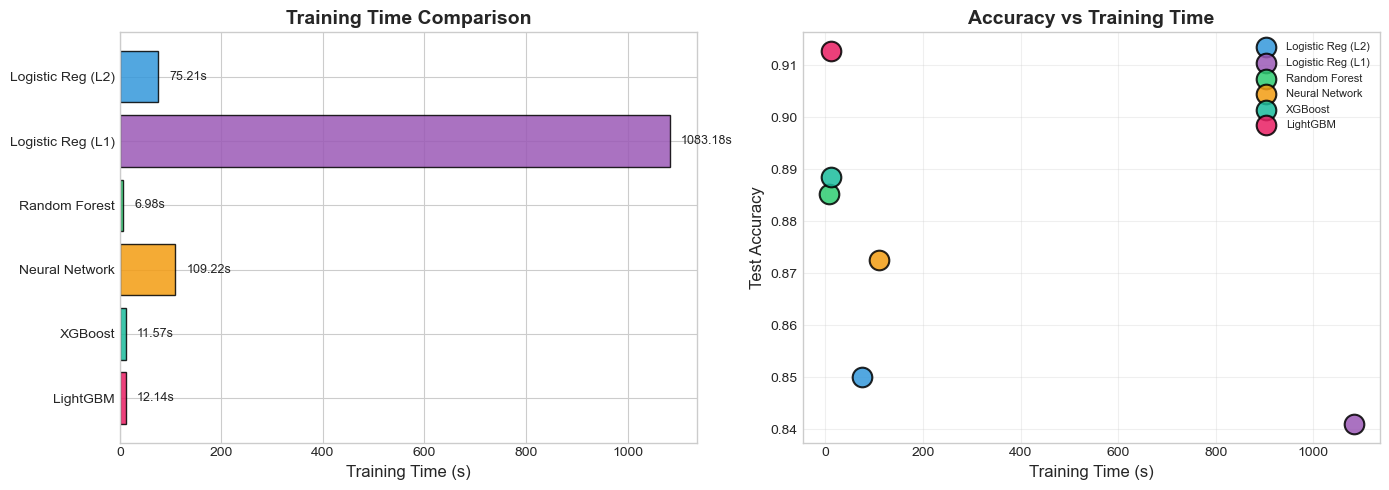

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
models = comparison_df['Model'].values
times = comparison_df['Train Time (s)'].values
colors = [MODEL_COLORS[m] for m in models]

bars = axes[0].barh(range(len(models)), times, color=colors, alpha=0.85, edgecolor='black')
axes[0].set_yticks(range(len(models)))
axes[0].set_yticklabels(models)
axes[0].invert_yaxis()
axes[0].set_xlabel('Training Time (s)', fontsize=12)
axes[0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
for bar, t in zip(bars, times):
    axes[0].text(t + max(times)*0.02, bar.get_y() + bar.get_height()/2, f'{t:.2f}s', va='center', fontsize=9)

# Scatter: Accuracy vs Time
for i, m in enumerate(models):
    axes[1].scatter(times[i], comparison_df['Test Acc'].values[i], s=200, c=MODEL_COLORS[m],
                    label=m, edgecolor='black', linewidth=1.5, alpha=0.85)
axes[1].set_xlabel('Training Time (s)', fontsize=12)
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Accuracy vs Training Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_time.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.5 Per-Class F1 Score

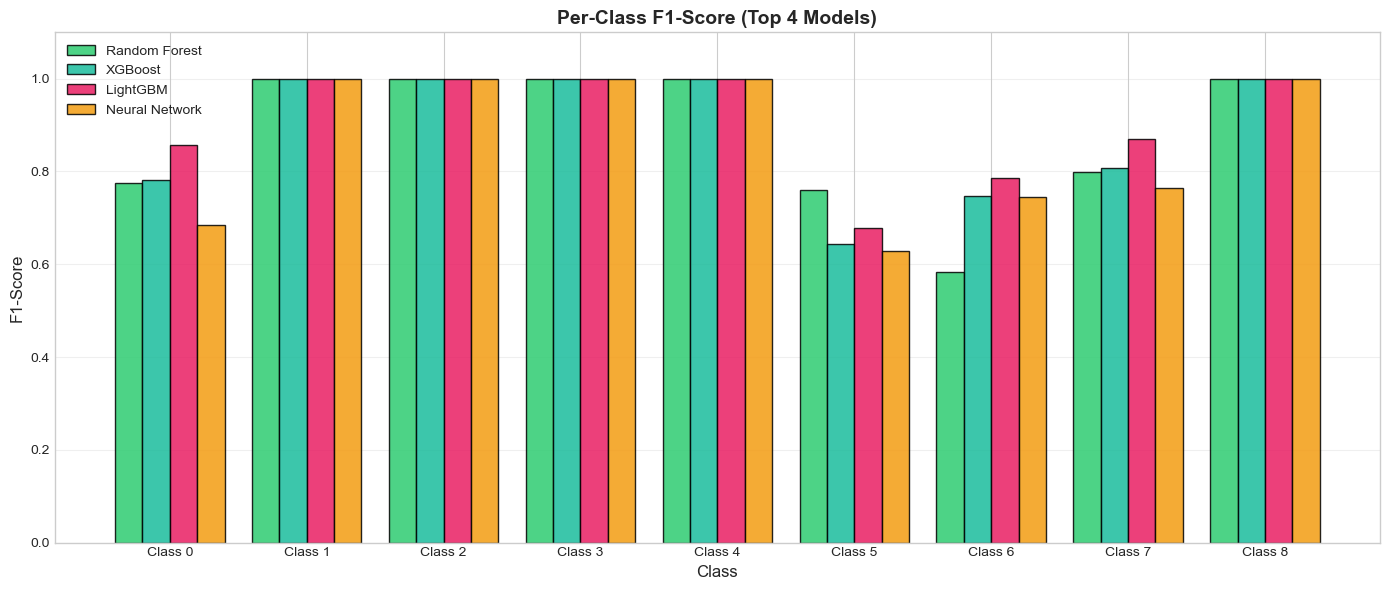

In [24]:
top_models = ['Random Forest', 'XGBoost', 'LightGBM', 'Neural Network']

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(n_classes)
width = 0.2

for i, model_name in enumerate(top_models):
    y_pred = model_results[model_name]['y_pred']
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    f1_scores = [report[str(c)]['f1-score'] for c in range(n_classes)]
    ax.bar(x + i*width, f1_scores, width, label=model_name, color=MODEL_COLORS[model_name], 
           alpha=0.85, edgecolor='black')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score (Top 4 Models)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([f'Class {i}' for i in range(n_classes)])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('per_class_f1.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.6 Feature Importance Comparison

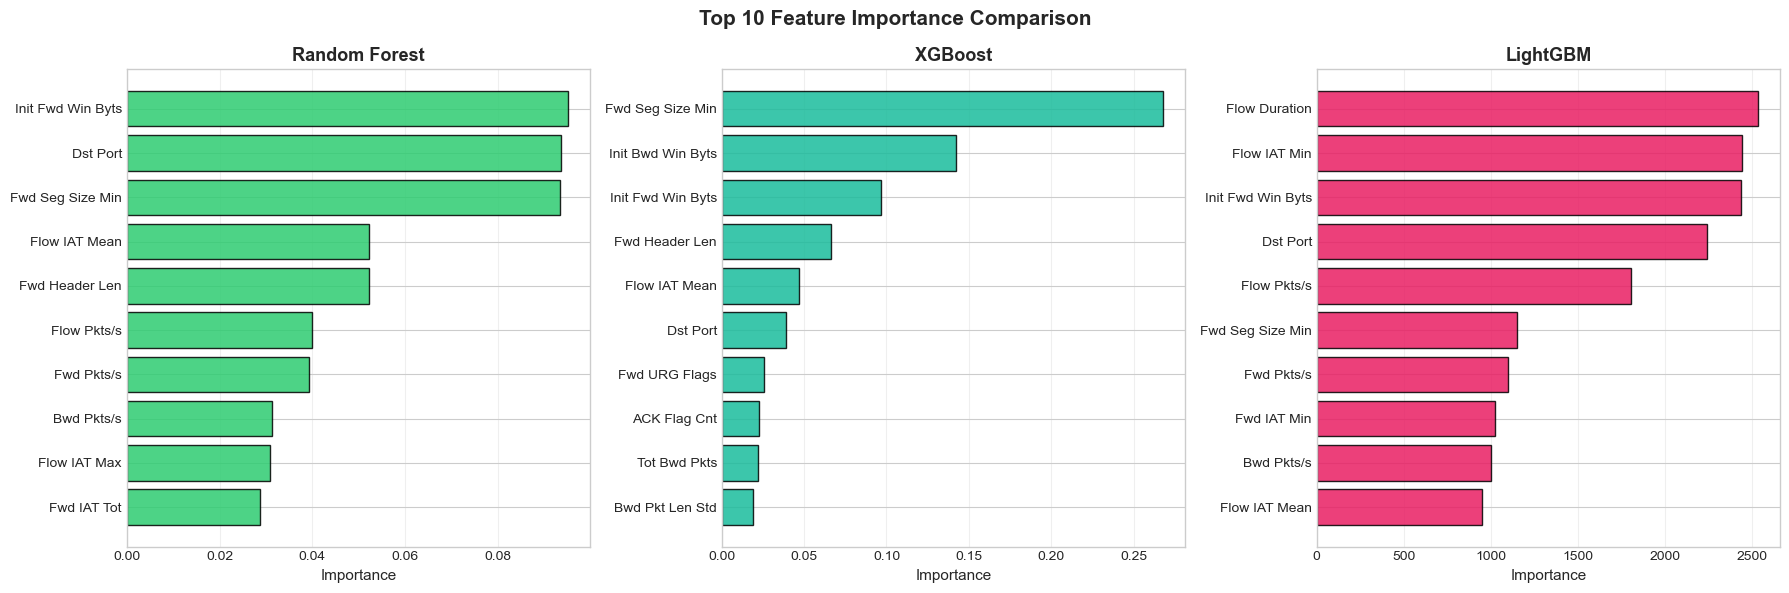

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
tree_models = ['Random Forest', 'XGBoost', 'LightGBM']

for ax, model_name in zip(axes, tree_models):
    imp = model_results[model_name]['model'].feature_importances_
    feat_imp = pd.DataFrame({'feature': X.columns, 'importance': imp}).sort_values('importance', ascending=True).tail(10)
    
    ax.barh(feat_imp['feature'], feat_imp['importance'], color=MODEL_COLORS[model_name], 
            alpha=0.85, edgecolor='black')
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Top 10 Feature Importance Comparison', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.7 ROC Curves

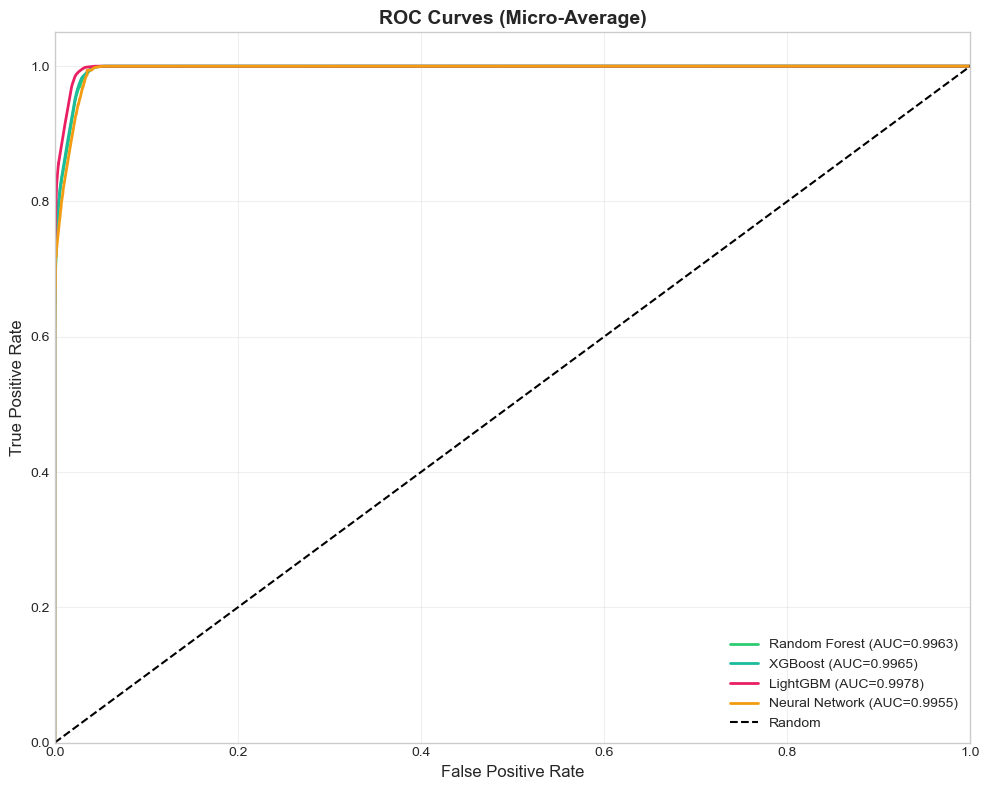

In [26]:
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fig, ax = plt.subplots(figsize=(10, 8))

prob_models = ['Random Forest', 'XGBoost', 'LightGBM', 'Neural Network']

for model_name in prob_models:
    model = model_results[model_name]['model']
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test_scaled)
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.4f})', 
                color=MODEL_COLORS[model_name], linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves (Micro-Average)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.8 Overfitting Analysis

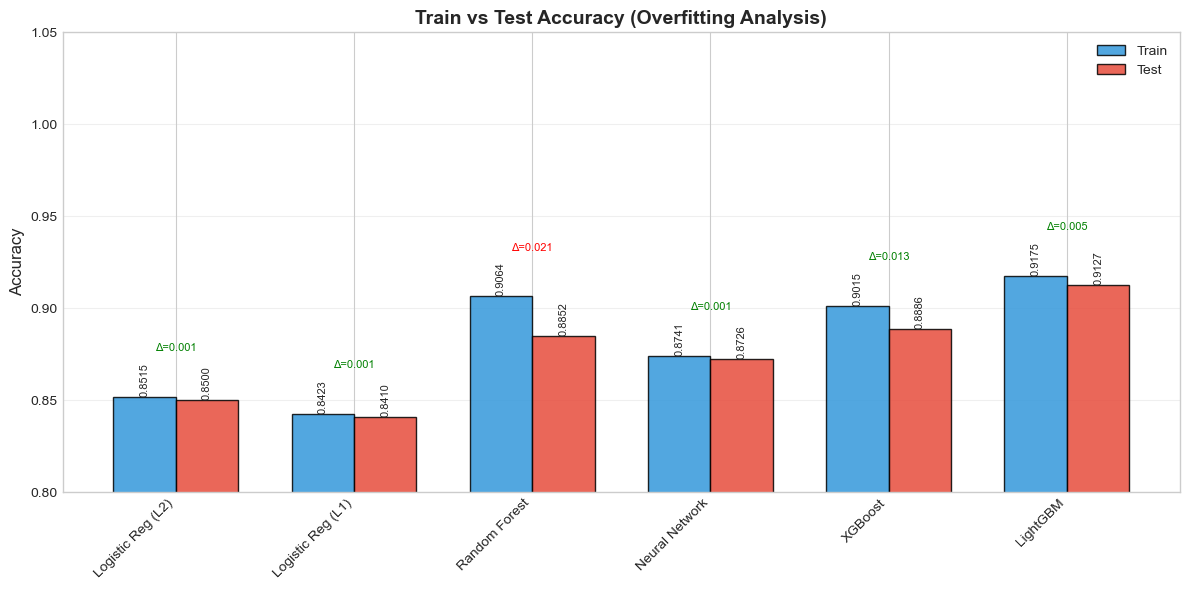

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

models = comparison_df['Model'].values
train_acc = comparison_df['Train Acc'].values
test_acc = comparison_df['Test Acc'].values

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_acc, width, label='Train', color='#3498db', alpha=0.85, edgecolor='black')
bars2 = ax.bar(x + width/2, test_acc, width, label='Test', color='#e74c3c', alpha=0.85, edgecolor='black')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.4f}',
            ha='center', va='bottom', fontsize=8, rotation=90)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height():.4f}',
            ha='center', va='bottom', fontsize=8, rotation=90)

# Overfitting gap
for i, (tr, te) in enumerate(zip(train_acc, test_acc)):
    gap = tr - te
    color = 'red' if gap > 0.02 else 'green'
    ax.annotate(f'Δ={gap:.3f}', xy=(i, max(tr, te) + 0.025), ha='center', fontsize=8, color=color)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Train vs Test Accuracy (Overfitting Analysis)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.8, 1.05])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('overfitting_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Cross-Validation

In [28]:
print('5-Fold Stratified Cross-Validation...')
print('='*60)

best_model_name = comparison_df.loc[comparison_df['Test Acc'].idxmax(), 'Model']
print(f'Best model: {best_model_name}\n')

# Select model
if 'XGBoost' in best_model_name:
    cv_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='mlogloss')
elif 'LightGBM' in best_model_name:
    cv_model = LGBMClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
else:
    cv_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_full = np.vstack([X_train_scaled, X_test_scaled])
y_full = np.concatenate([y_train, y_test])

cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_full, y_full), 1):
    cv_model.fit(X_full[train_idx], y_full[train_idx])
    y_pred = cv_model.predict(X_full[val_idx])
    
    cv_scores['accuracy'].append(accuracy_score(y_full[val_idx], y_pred))
    cv_scores['precision'].append(precision_score(y_full[val_idx], y_pred, average='weighted', zero_division=0))
    cv_scores['recall'].append(recall_score(y_full[val_idx], y_pred, average='weighted', zero_division=0))
    cv_scores['f1'].append(f1_score(y_full[val_idx], y_pred, average='weighted', zero_division=0))
    
    print(f'Fold {fold}: Acc={cv_scores["accuracy"][-1]:.4f}, F1={cv_scores["f1"][-1]:.4f}')

print('\n' + '='*60)
print('Results (Mean ± Std):')
for metric, scores in cv_scores.items():
    print(f'  {metric.capitalize():12s}: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

5-Fold Stratified Cross-Validation...
Best model: LightGBM

Fold 1: Acc=0.9141, F1=0.9117
Fold 2: Acc=0.9123, F1=0.9099
Fold 3: Acc=0.9140, F1=0.9111
Fold 4: Acc=0.9128, F1=0.9099
Fold 5: Acc=0.9134, F1=0.9107

Results (Mean ± Std):
  Accuracy    : 0.9133 ± 0.0007
  Precision   : 0.9257 ± 0.0014
  Recall      : 0.9133 ± 0.0007
  F1          : 0.9106 ± 0.0007


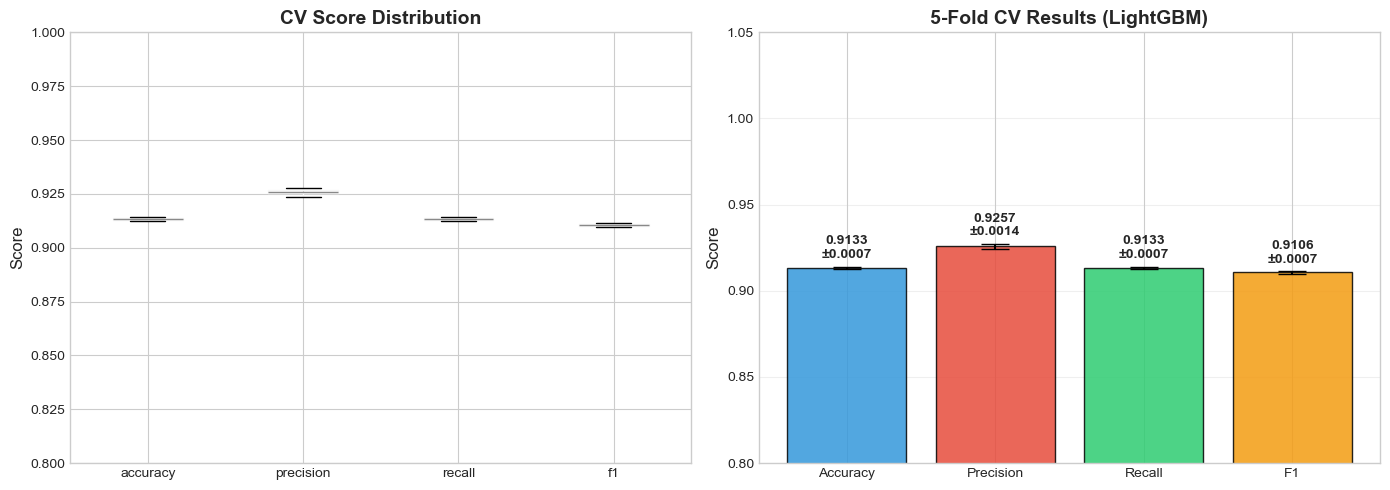

In [29]:
# CV visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
pd.DataFrame(cv_scores).boxplot(ax=axes[0], grid=True)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('CV Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.8, 1.0])

# Bar plot
metrics_list = list(cv_scores.keys())
means = [np.mean(cv_scores[m]) for m in metrics_list]
stds = [np.std(cv_scores[m]) for m in metrics_list]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = axes[1].bar(range(len(metrics_list)), means, yerr=stds, capsize=10, 
                   color=colors, alpha=0.85, edgecolor='black')
for bar, mean, std in zip(bars, means, stds):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + std + 0.005,
                 f'{mean:.4f}\n±{std:.4f}', ha='center', fontsize=10, fontweight='bold')

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title(f'5-Fold CV Results ({best_model_name})', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(metrics_list)))
axes[1].set_xticklabels([m.capitalize() for m in metrics_list])
axes[1].set_ylim([0.8, 1.05])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('cross_validation.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Summary

In [30]:
print('\n' + '='*80)
print('FINAL SUMMARY')
print('='*80)

print(f'\n📊 Dataset: {len(df):,} samples, {X.shape[1]} features, {n_classes} classes')

print('\n🏆 Model Ranking (Test Accuracy):')
for i, (_, row) in enumerate(comparison_df.sort_values('Test Acc', ascending=False).iterrows(), 1):
    print(f'   {i}. {row["Model"]}: {row["Test Acc"]:.4f} (F1: {row["F1-Score"]:.4f}, Time: {row["Train Time (s)"]:.2f}s)')

print('\n📈 Cross-Validation (Best Model):')
for metric, scores in cv_scores.items():
    print(f'   {metric.capitalize()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

print('\n🔍 Top 5 Features:')
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    print(f'   {i}. {row["feature"]}: {row["importance"]:.4f}')

print('\n' + '='*80)


FINAL SUMMARY

📊 Dataset: 360,000 samples, 78 features, 9 classes

🏆 Model Ranking (Test Accuracy):
   1. LightGBM: 0.9127 (F1: 0.9102, Time: 12.14s)
   2. XGBoost: 0.8886 (F1: 0.8865, Time: 11.57s)
   3. Random Forest: 0.8852 (F1: 0.8797, Time: 6.98s)
   4. Neural Network: 0.8726 (F1: 0.8689, Time: 109.22s)
   5. Logistic Reg (L2): 0.8500 (F1: 0.8456, Time: 75.21s)
   6. Logistic Reg (L1): 0.8410 (F1: 0.8365, Time: 1083.18s)

📈 Cross-Validation (Best Model):
   Accuracy: 0.9133 ± 0.0007
   Precision: 0.9257 ± 0.0014
   Recall: 0.9133 ± 0.0007
   F1: 0.9106 ± 0.0007

🔍 Top 5 Features:
   1. Init Fwd Win Byts: 0.0951
   2. Dst Port: 0.0935
   3. Fwd Seg Size Min: 0.0933
   4. Flow IAT Mean: 0.0522
   5. Fwd Header Len: 0.0521



In [31]:
# Save results
comparison_df.to_csv('model_comparison.csv', index=False)
print('Results saved to model_comparison.csv')

import os
saved_figs = [f for f in os.listdir('.') if f.endswith('.png')]
print(f'\nSaved {len(saved_figs)} figures:')
for f in sorted(saved_figs):
    print(f'  - {f}')

Results saved to model_comparison.csv

Saved 13 figures:
  - class_distribution.png
  - confusion_matrices.png
  - cross_validation.png
  - feature_importance_comparison.png
  - feature_importance_rf.png
  - model_comparison_zoomed.png
  - overfitting_analysis.png
  - pca_2d.png
  - pca_variance.png
  - per_class_f1.png
  - radar_chart.png
  - roc_curves.png
  - training_time.png
